# Steganography: Hiding Star Wars in Images

Steganography is the practice of concealing a file, message, image, or video within another file, message, image, or video. Whereas cryptography is the practice of protecting the contents of a message alone, steganography is concerned with concealing the fact that a secret message is being sent as well as concealing the contents of the message. (https://en.wikipedia.org/wiki/Steganography) This notebook will use least significant bit steganography to hide 100s of KB to several MB of data in an image without perceptibly changing the image. This notebook completes 3 tasks using this method:

**Part 1: Encode all 3 of the original Star Wars scripts into an image of the Death Star.**

**Part 2: Encode an image of R2D2 with an image of the Death Star Plans.**

**Part 3: Encode a series of encoded images within encoded images and end with the script for A New Hope (Death Star => X-Wing => R2D2 => Death Star Plans => New Hope Script).**


This is my attempt to duplicate the method without looking up tutorials or code samples on least significant bit steganography. My only knowledge going into this is a basic description of the method. 

# Least Significant Bit Image Steganography Explained

Here is a quick rundown of how this works. Each pixel in a color image has a value for each of it's 3 color channel. These values are between 0 and 255 corresponding to how red, green, or blue that pixel is. These values can be converted to an 8 bit binary value (255 = 11111111, ect.). While changing the left-most bits can mean a lot of change to the value, the rightmost bits mean very little. We are going use the rightmost 2 bits for our encoding. Changing these 2 bits will change the value for that one color channel on that one pixel by *at most* 3 points but more likely less or not at all. The result is a difference in the final image that is imperceptible to the human eye. If we are willing to replace these 2 bits of the 8 bit value, we can use up to 1/4th of the image's total space for whatever else we want! If we convert our scripts to 8 bit binary as well, there is more than enough space in a single color image to replace the last 2 bits of each color channel with our scripts.

(Even more bits could be used for encoding. This allows for using more of the image's total space but runs the risk of making the changes more visible. The last 2 bits is plenty for this notebook and most encodings. )


# Imports

In [1]:
import numpy as np
import pandas as pd
import skimage
from skimage.io import imread, imshow
from skimage.transform import rescale

import bitarray
import matplotlib.pyplot as plt
%matplotlib inline

import os
print(os.listdir("input"))

# 한 셀에 복수개의 라인 출력 (print문 없이)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

['star-wars-movie-scripts', 'star-wars-steganography-images']


# Part 1: Encode the Original Star Wars Scripts into an Image

# Clean and Combine Scripts

Lets combine all three scripts into one string. Clean them up a bit so that they look pretty in this new format while we are at it.

In [2]:
All_SW_Scripts = ""

def TextToString(txt):
    with open(txt, "r") as file:
        data=file.readlines()
        script = ""

        for x in data[1:]:
            x = x.replace('"','').replace("\n"," \n ").split(' ')
            x[1] += ":"
            script += " ".join(x[1:-1]).replace("\n"," \n ")
            #script += " ".join(x[1:-1])
        return script

All_SW_Scripts += TextToString("input/star-wars-movie-scripts/SW_EpisodeIV.txt")
All_SW_Scripts += TextToString("input/star-wars-movie-scripts/SW_EpisodeV.txt")
All_SW_Scripts += TextToString("input/star-wars-movie-scripts/SW_EpisodeVI.txt")

len(All_SW_Scripts)
print('\n')
print(All_SW_Scripts[:1000])

167037



THREEPIO: Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!  
 THREEPIO: We're doomed!  
 THREEPIO: There'll be no escape for the Princess this time.  
 THREEPIO: What's that?  
 THREEPIO: I should have known better than to trust the logic of a half-sized thermocapsulary dehousing assister...  
 LUKE: Hurry up!  Come with me!  What are you waiting for?!  Get in gear!  
 THREEPIO: Artoo! Artoo-Detoo, where are you?  
 THREEPIO: At last!  Where have you been?  
 THREEPIO: They're heading in this direction. What are we going to do?  We'll be sent to the spice mines of Kessel or smashed into who knows what!  
 THREEPIO: Wait a minute, where are you going?  
 IMPERIAL: OFFICER The Death Star plans are not in the main computer.  
 VADER: Where are those transmissions you intercepted?  
 REBEL: OFFICER We intercepted no transmissions. Aaah...  This is a consular ship. Were on a diplomatic mission.  
 VADER: If this is a consular ship... 

# Get and Examane the Death Star Image
Now we will read in and examine our first image.

Image is 559 by 561 pixels with 3 color channels


<Figure size 720x720 with 0 Axes>

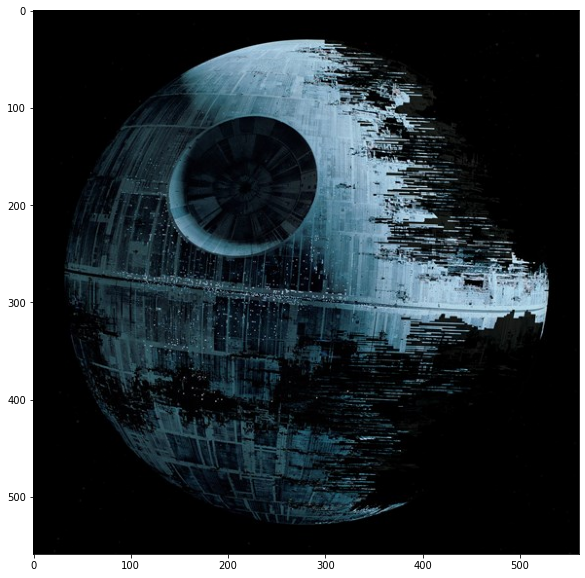

In [3]:
deathstar_img = imread("input/star-wars-steganography-images/Death-Star.jpg")

print("Image is "+str(deathstar_img.shape[0])+" by "+str(deathstar_img.shape[1])+
      " pixels with "+str(deathstar_img.shape[2])+" color channels")

plt.figure(figsize=(10, 10))
plt.imshow(deathstar_img)

In [4]:
deathstar_img.shape

(559, 561, 3)

# Scripts to Bits
In order to encode our scripts into an image, we are going to need to convert the characters into bits. Let's start by making that method.


In [5]:
def MessageToBits(message):
    #tag message (and pad w/ spaces till 10 characters)
    tag = "{:<10}".format(str(len(message)*8)) # tag : length of message bits, 10 Characters
    print(tag, len(tag))
    message = tag+message # str(len(message)*8) + message
    #convert to bits
    code = bitarray.bitarray()
    code.frombytes(message.encode('utf-8'))
    code = "".join(['1' if x == True else '0' for x in code.tolist()])
    return code

## Check
Code = MessageToBits(All_SW_Scripts)
print(All_SW_Scripts[:500])
print(All_SW_Scripts.encode('utf-8')[:500])
print(type(Code))

1336296    10
THREEPIO: Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!  
 THREEPIO: We're doomed!  
 THREEPIO: There'll be no escape for the Princess this time.  
 THREEPIO: What's that?  
 THREEPIO: I should have known better than to trust the logic of a half-sized thermocapsulary dehousing assister...  
 LUKE: Hurry up!  Come with me!  What are you waiting for?!  Get in gear!  
 THREEPIO: Artoo! Artoo-Detoo, where are you?  
 THREEPIO: At last!  Where
b"THREEPIO: Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!  \n THREEPIO: We're doomed!  \n THREEPIO: There'll be no escape for the Princess this time.  \n THREEPIO: What's that?  \n THREEPIO: I should have known better than to trust the logic of a half-sized thermocapsulary dehousing assister...  \n LUKE: Hurry up!  Come with me!  What are you waiting for?!  Get in gear!  \n THREEPIO: Artoo! Artoo-Detoo, where are you?  \n T

# Check File Size and Image Encoding Space
This part is just simple math. We want to double check the size of our scripts files and how much space we can encode in our image. The script size is just going to be the length of the string in characters times 8 (or equal to the length after 8 bit converstion). We are going to use the last 2 bits for our encoding. So the bit space we have to work with in the image will be equal to height x width x color channels x 2 bits. Lets make a method that compares these two values and returns True or False if there is enough space. Printing the results in KB by dividing by 8000 for easy reading.

In [6]:
def CheckBitSize(img, message):
    h = img.shape[0]
    w = img.shape[1]
    try:
        c = img.shape[2]
    except:
        c = 1
    image_max_size = h*w*c*2
    string_size = len(message)
    print("Message is "+str(string_size/8000)+" KB and image can fit "
          +str(image_max_size/8000)+" KB of data")
    if string_size > image_max_size:
        print("Message is too big to be encoded in image")
        return False
    else:
        print("Image can be encoded with message. Proceed")
        return True
    
CheckBitSize(deathstar_img, MessageToBits(All_SW_Scripts))    

1336296    10
Message is 167.047 KB and image can fit 235.19925 KB of data
Image can be encoded with message. Proceed


True

Wow, even though we are only using the last 2-bits of data for our encoding, we still have over 235KB to work with in a modest color image. The ~167KB for all the Star Wars scripts checks outs since, if you add up their .txt file sizes it is pretty close at 177KB. (The only reason for the difference in size is the cleaning done earlier, removing the quotes and line numbering)

# Encode the Image
Here is how the method works.:
1. Adds the length of our message in bits as a tag at the start for decoding later, padded with spaces to 10 characters for consitantcy
2. Converts message into bits and makes them a string of 1s and 0s.
3. Uses our CheckBitSize to make sure we have space.
4. Goes through the image pixel by pixel and changes the last 2 bits in every 8 bit color channel value to our message in sequence
5. When the last bit of the message is encoded, returns the image.

In [7]:
# Test

x = 255
print(x)
codex=['0','0']
print(list('{0:08b}'.format(x)))
zbits = list('{0:08b}'.format(x))[:6]+codex[0:2]
print(zbits)
print("".join(zbits))
y = int("".join(zbits), 2)
print(y)


255
['1', '1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '0', '0']
11111100
252


In [8]:
%%time
def EncodeImage(img, message):
    code = MessageToBits(message)
    if CheckBitSize(img, code):
        shape = img.shape
        img = img.flatten()  # (H*W*C, ) = (940797,)
        code = list(code)
        code_len = len(code) # 1336376
        for i,x in enumerate(img):
            if i*2 <code_len:
                zbits = list('{0:08b}'.format(x))[:6]+code[i*2:i*2+2]
                img[i] = int("".join(zbits), 2)
            else:
                return img.reshape(shape)
        return img.reshape(shape)

encoded_img = EncodeImage(deathstar_img, All_SW_Scripts)

1336296    10
Message is 167.047 KB and image can fit 235.19925 KB of data
Image can be encoded with message. Proceed
Wall time: 1.24 s


# Compare the Original to the Coded Images
Take a good look. Can you spot any difference between the 2?

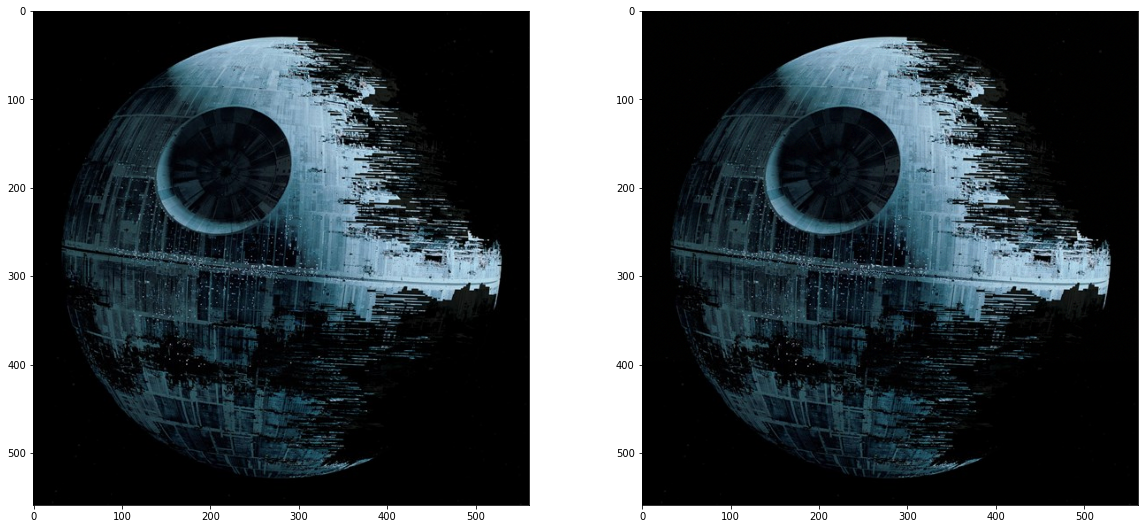

In [9]:
def CompareTwoImages(img1,img2):
    fig=plt.figure(figsize=(20, 20))

    fig.add_subplot(2, 2, 1)
    plt.imshow(img1)
    fig.add_subplot(2, 2, 2)
    plt.imshow(img2)

    plt.show()
CompareTwoImages(deathstar_img, encoded_img)

They look like the same image copied twice but the one on the right has all 167KB of the Star Wars scripts encoded. Using only the last 2 bits of each pixels color channel only changes the values by such a small amount we cannot tell the difference. Lets look at a pixel in the middle to show that the values are in fact *a little bit* different.

In [10]:
print(deathstar_img[200][200])
print(encoded_img[200][200])

[ 5  4 12]
[ 5  6 15]


# Decode the Image
So now we need a method to read the out the scripts. Here is how it works:
1. Goes through the image pixel by pixel till it reads the first 10 charaters in our tag (80 bits)
2. Check that it does have a number tag and uses that to know how many more bits to read before it has the whole message
3. Converts the bits back into a string of characters and returns it

In [11]:
%%time
def DecodeImage(img):
    bit_message = ""
    bit_count = 0
    bit_length = 200
    for i,x in enumerate(img):    # img.shape=(h,w,c), x.shape=(w,c), y.shape(c,)
        for j,y in enumerate(x):
            for k,z in enumerate(y):
                zbits = '{0:08b}'.format(z)
                bit_message += zbits[-2:]
                bit_count += 2
                if bit_count == 80:
                    try:
                        decoded_tag = bitarray.bitarray(bit_message).tobytes().decode('utf-8')
                        print(type(decoded_tag), int(decoded_tag))
                        bit_length = int(decoded_tag)+80
                        print(bit_length)
                        bit_message = ""
                    except:
                        print("Image does not have decode tag."+
                              "Image is either not encoded or, at least,"+ 
                              "not encoded in a way this decoder recognizes")
                        return
                elif bit_count >= bit_length:
                    return bitarray.bitarray(bit_message).tobytes().decode('utf-8')

decoded_message = DecodeImage(encoded_img)
print(decoded_message[:1000])

<class 'str'> 1336296
1336376
THREEPIO: Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!  
 THREEPIO: We're doomed!  
 THREEPIO: There'll be no escape for the Princess this time.  
 THREEPIO: What's that?  
 THREEPIO: I should have known better than to trust the logic of a half-sized thermocapsulary dehousing assister...  
 LUKE: Hurry up!  Come with me!  What are you waiting for?!  Get in gear!  
 THREEPIO: Artoo! Artoo-Detoo, where are you?  
 THREEPIO: At last!  Where have you been?  
 THREEPIO: They're heading in this direction. What are we going to do?  We'll be sent to the spice mines of Kessel or smashed into who knows what!  
 THREEPIO: Wait a minute, where are you going?  
 IMPERIAL: OFFICER The Death Star plans are not in the main computer.  
 VADER: Where are those transmissions you intercepted?  
 REBEL: OFFICER We intercepted no transmissions. Aaah...  This is a consular ship. Were on a diplomatic mission.  
 VADER: If

Now that looks like an exact copy of the script we fed in! Let's double check:

In [12]:
print(decoded_message == All_SW_Scripts)

True


 Success! Lets save the image and see what else we can do!

In [13]:
skimage.io.imsave("Death_Star_With_Scripts.bmp", encoded_img)

# Part 2: Lets Encode an Image *Inside* Another Image
That is a great start but what else could we encode? We don't have to just encode text, we could use any data we want. Maybe we could even encode images inside images. Keeping with the Star Wars theme, lets now encode R2D2 with the death star plans. Maybe Princess Leia decides to post a photo of her favorite droid R2D2 (that is right I said *favorite* droid. Stop your whining C3PO) with the plans hidden inside for her rebel pals. Think that the empire would not fall for that? Failing to shoot down an escape pod just because there were no life signs on board says otherwise. 

# Check our New Images
Let's start with the Death Star plans image. The Death Star plans original image was in color but I changed it to grayscale to give it that nice schematic look and cut the amount of data we'll need to encode by 1/3rd ( Each pixel will only have 1 value to encode instead of 3).


<Figure size 720x720 with 0 Axes>

Image is 550 by 550 pixels
(550, 550)


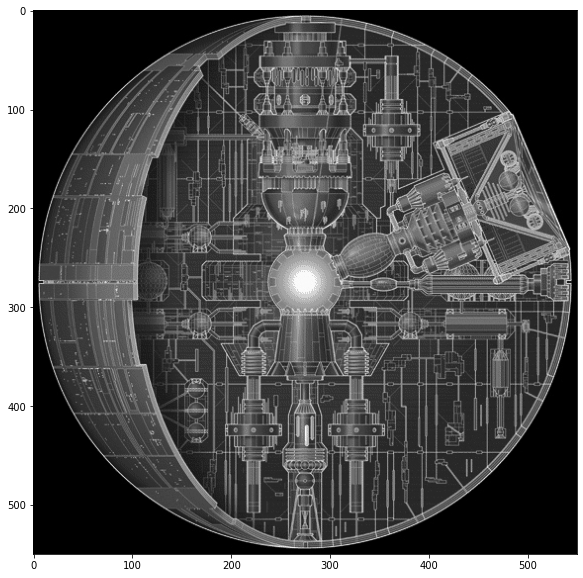

In [14]:
plans_img = imread("input/star-wars-steganography-images/Deathstar_blueprint.jpg")

plt.figure(figsize=(10, 10))
plt.imshow(plans_img, cmap="gray")

print("Image is "+str(plans_img.shape[0])+" by "+str(plans_img.shape[1])+" pixels")
print(plans_img.shape)

Now the R2D2 image I pulled off of Wookieepedia is huge at 2550 by 1700 pixels. That is *way* more space than we need. We could encode the full color Death Star plans a few times over.  Doing the math, a ~636 by 636 pixel color image should be just enough to encode our 550 by 550 greyscale plans image with the 2 bit encoding (or just over 400,000 color pixels). Rounding up a bit, here is a 775 by 550 pixels version.

<Figure size 720x720 with 0 Axes>

Image is 775 by 550 pixels with 3 color channels


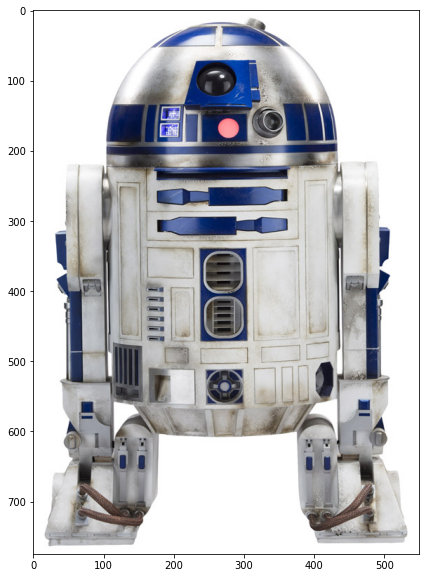

In [15]:
r2d2_img = imread("input/star-wars-steganography-images/R2D2.jpg")

plt.figure(figsize=(10, 10))
plt.imshow(r2d2_img)

print("Image is "+str(r2d2_img.shape[0])+" by "+str(r2d2_img.shape[1])
      +" pixels with "+str(r2d2_img.shape[2])+" color channels")

# Image to String of Bits

Now we need a method to convert the image into a nice string of bits. We are going to expand the tag at the begining to 20 spaces and add more information like data type for our decoder.

In [16]:
def ImageToBits(img):
    try:
        channels = str(img.shape[2])
    except:
        channels = "1"
    tag = "{:<20}".format("img,"+str(img.shape[0])+","+str(img.shape[1])+","+channels)
    #convert tag to bits
    code = bitarray.bitarray()
    code.frombytes(tag.encode('utf-8'))
    tag = "".join(['1' if x == True else '0' for x in code.tolist()])
    # combine tag bits with the images bits
    bits_string = tag + ''.join(['{0:08b}'.format(x) for x in list(img.flatten())])
    return bits_string
    
test_image_bits = ImageToBits(plans_img)
print(test_image_bits[:1000])

0110100101101101011001110010110000110101001101010011000000101100001101010011010100110000001011000011000100100000001000000010000000100000001000000010000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

Let's also alter our MessageToBits method to include this new expanded tag.

In [17]:
def MessageToBits(message):
    #tag message (and pad w/ spaces till 20 characters)
    tag = "{:<20}".format("text,"+str(len(message)*8))
    message = tag+message
    #convert to bits
    code = bitarray.bitarray()
    code.frombytes(message.encode('utf-8'))
    code = "".join(['1' if x == True else '0' for x in code.tolist()])
    return code

# String of Bits to Image
We naturally also need a method to convert this string of bits back into an image.

<Figure size 720x720 with 0 Axes>

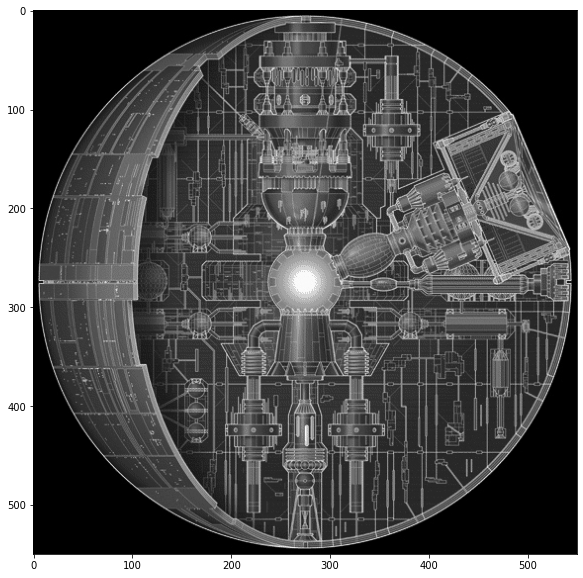

In [18]:
def BitsToImage(bits_string):
    try:
        tag = bits_string[:160]
        tag = bitarray.bitarray(tag).tobytes().decode('utf-8')
        tag = tag.split(",")
        image_bits = bits_string[160:]
        h = int(tag[1])
        w = int(tag[2])
        c = int(tag[3])
        image_bits = np.asarray([int(image_bits[i:i+8], 2) for i in range(0, len(image_bits), 8)])
        if c == 1:
            image_bits = image_bits.reshape([h,w])
        else:
            image_bits = image_bits.reshape([h,w,c])
        return image_bits.astype(np.uint8)
    except:
        print('Not a string of image bits')
    
output_test = BitsToImage(test_image_bits)

plt.figure(figsize=(10, 10))
plt.imshow(output_test, cmap="gray")

# Update the Encoder Method
Update the encoder method to work on either strings or image inputs.

In [19]:
%%time
def EncodeImage(img, message):
    if type(message) is str:
        code = MessageToBits(message)
    else:
        code = ImageToBits(message)
    if CheckBitSize(img, code):
        shape = img.shape
        img = img.flatten()
        code = list(code)
        code_len = len(code)
        for i,x in enumerate(img):
            if i*2 <code_len:
                zbits = list('{0:08b}'.format(x))[:6]+code[i*2:i*2+2]
                img[i] = int("".join(zbits), 2)
            else:
                return img.reshape(shape)
        return img.reshape(shape)

encoded_img = EncodeImage(r2d2_img, plans_img)

Message is 302.52 KB and image can fit 319.6875 KB of data
Image can be encoded with message. Proceed
Wall time: 2.45 s


# Check the Images
Same as last time, they are the same as last time.

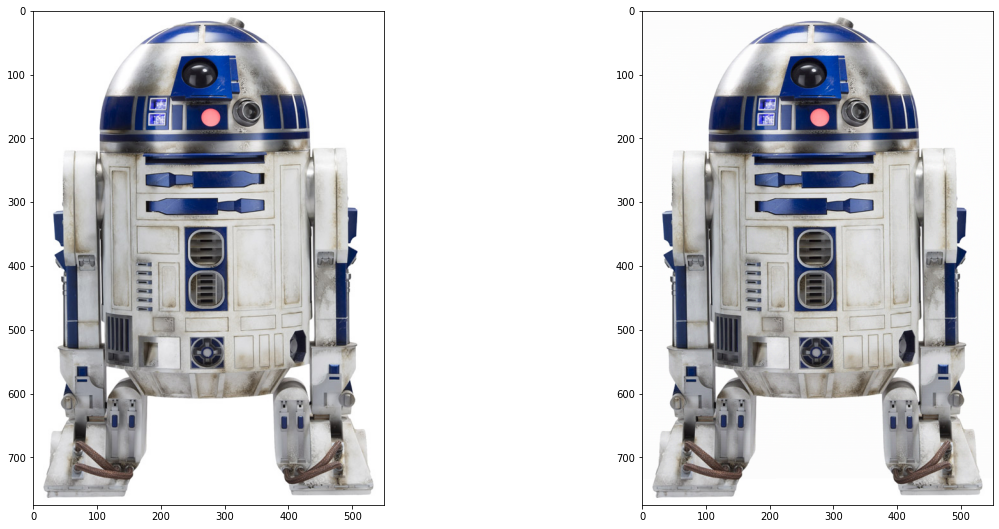

In [20]:
CompareTwoImages(r2d2_img, encoded_img)

In [21]:
print(r2d2_img[200][200])
print(encoded_img[200][200])

[ 92 112 163]
[ 92 113 162]


# Update the Decoder Method
Now the decoder needs updating to account for our new image inside image encoding.

In [22]:
%%time
def DecodeImage(img):
    bit_message = ""
    bit_count = 0
    bit_length = 200
    grey = len(img.shape) == 2
    for i,x in enumerate(img):
        for j,y in enumerate(x):
            if grey:
                y = [y]
            for k,z in enumerate(y):
                zbits = '{0:08b}'.format(z)
                # print(zbits[-2:])
                bit_message += zbits[-2:]
                bit_count += 2
                if bit_count == 160:
                    try:
                        decoded_tag = bitarray.bitarray(bit_message).tobytes().decode('utf-8').split(",")
                        message_type = decoded_tag[0]
                        if message_type == "text":  
                            bit_length = int(decoded_tag[1])+160
                            bit_message = ""
                        else:
                            bit_length = (int(decoded_tag[1])*int(decoded_tag[2])*int(decoded_tag[3])*8)+160
                    except:
                        print("Image does not have decode tag. Image is either not encoded or," + 
                              "at least, not encoded in a way this decoder recognizes")
                        return
                elif bit_count >= bit_length:
                    if message_type == "text":
                        return bitarray.bitarray(bit_message).tobytes().decode('utf-8')
                    else:
                        return BitsToImage(bit_message)

decoded_img = DecodeImage(encoded_img)

Wall time: 1.93 s


# Show Results

<Figure size 720x720 with 0 Axes>

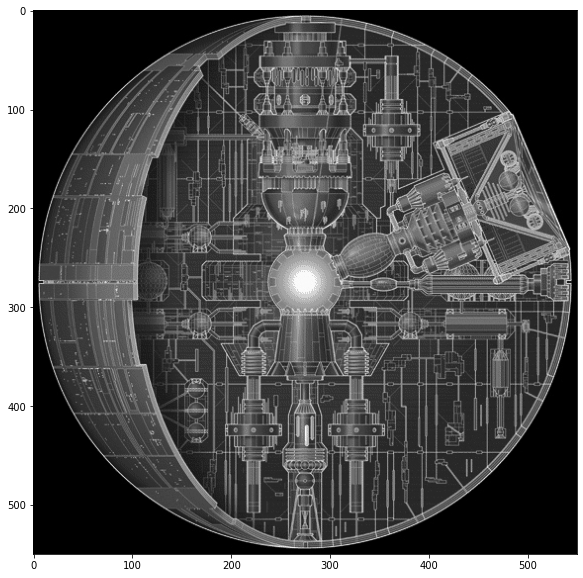

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(decoded_img, cmap="gray")

Success! We have successfully deconstructed an image, encoded it in another, and decoded it back again. 

# Part 3: Let's Make a Nesting Doll of Star Wars Images
How far can we go with this? Let's try encoding encoded images in encoded images. We are going to make:
1.An HD wallpaper image of the Death Star
1. Encoded with an image of an X-wing
2. Encoded with an R2D2 image
3. That is ecoded with plans for the Death Star
4. That is encoded with the script for A New Hope

Using are last 2 bit encoding, each step has 1/4th the size of the last but we can still make this work.
# Yet More Images
2 final images for our notebook. These are much larger than the previous and provides us with tons of pixels to work with.

In [24]:
New_Hope_Script = TextToString("input/star-wars-movie-scripts/SW_EpisodeIV.txt")

<Figure size 720x720 with 0 Axes>

Image is 2048 by 4096 pixels with 3 color channels


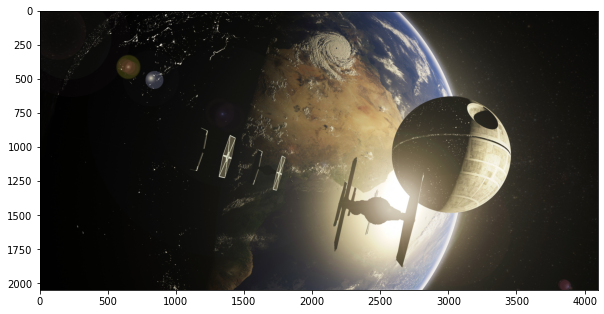

In [25]:
death_star_hd_img = imread("input/star-wars-steganography-images/death_star_HD.jpg")

plt.figure(figsize=(10, 10))
plt.imshow(death_star_hd_img)

print("Image is "+str(death_star_hd_img.shape[0])+" by "+str(death_star_hd_img.shape[1])
      +" pixels with "+str(death_star_hd_img.shape[2])+" color channels")

<Figure size 720x720 with 0 Axes>

Image is 1068 by 2000 pixels with 3 color channels


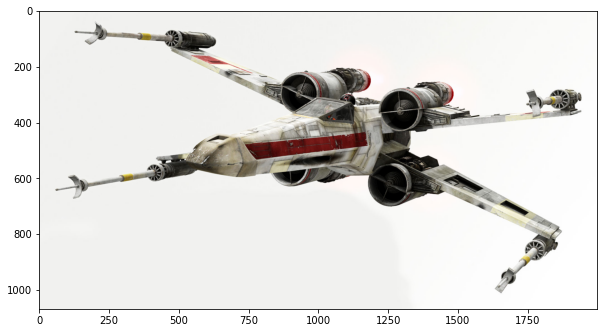

In [26]:
xwing_img = imread("input/star-wars-steganography-images/x-wing.jpg")

plt.figure(figsize=(10, 10))
plt.imshow(xwing_img)

print("Image is "+str(xwing_img.shape[0])+" by "+str(xwing_img.shape[1])
      +" pixels with "+str(xwing_img.shape[2])+" color channels")

# Check for Space
In part 2, I checked if the images would fit by calculator and photoshop. No reason to do, that outside of math practice, when we have these nice methods already.


In [27]:
CheckBitSize(xwing_img, ImageToBits(r2d2_img))

Message is 1278.77 KB and image can fit 1602.0 KB of data
Image can be encoded with message. Proceed


True

In [28]:
CheckBitSize(death_star_hd_img, ImageToBits(xwing_img))

Message is 6408.02 KB and image can fit 6291.456 KB of data
Message is too big to be encoded in image


False

# Rescale the X-Wing
Looks like the X-wing will not *quite* fit in our wallpaper. Unlike last time, I will adjust the image within this notebook.

<Figure size 720x720 with 0 Axes>

Image is 1015 by 1900 pixels with 3 color channels


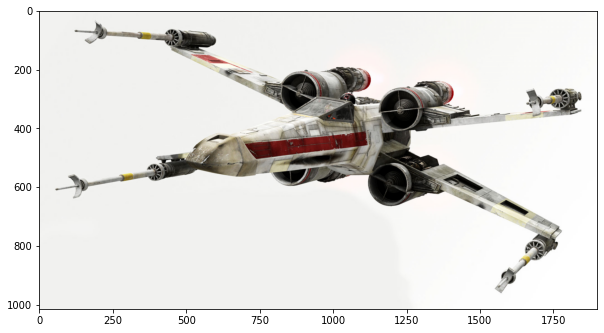

In [29]:
r_xwing_img = (rescale(xwing_img, 0.95) * 255).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(r_xwing_img)

print("Image is "+str(r_xwing_img.shape[0])+" by "+str(r_xwing_img.shape[1])
      +" pixels with "+str(r_xwing_img.shape[2])+" color channels")

In [30]:
CheckBitSize(death_star_hd_img, ImageToBits(r_xwing_img))

Message is 5785.52 KB and image can fit 6291.456 KB of data
Image can be encoded with message. Proceed


True

Now lets double check that the whole series will fit before moving on.

In [31]:
CheckBitSize(death_star_hd_img, ImageToBits(r_xwing_img))
CheckBitSize(r_xwing_img, ImageToBits(r2d2_img))
CheckBitSize(r2d2_img, ImageToBits(plans_img))
CheckBitSize(plans_img, MessageToBits(New_Hope_Script))

Message is 5785.52 KB and image can fit 6291.456 KB of data
Image can be encoded with message. Proceed


True

Message is 1278.77 KB and image can fit 1446.375 KB of data
Image can be encoded with message. Proceed


True

Message is 302.52 KB and image can fit 319.6875 KB of data
Image can be encoded with message. Proceed


True

Message is 72.308 KB and image can fit 75.625 KB of data
Image can be encoded with message. Proceed


True

# Encode the Series

In [32]:
%%time
nested_img = EncodeImage(plans_img, New_Hope_Script)
print("1st encode done")
nested_img = EncodeImage(r2d2_img, nested_img)
print("2nd encode done")
nested_img = EncodeImage(r_xwing_img, nested_img)
print("3rd encode done")
nested_img = EncodeImage(death_star_hd_img, nested_img)
print("4th encode done")

Message is 72.308 KB and image can fit 75.625 KB of data
Image can be encoded with message. Proceed
1st encode done
Message is 302.52 KB and image can fit 319.6875 KB of data
Image can be encoded with message. Proceed
2nd encode done
Message is 1278.77 KB and image can fit 1446.375 KB of data
Image can be encoded with message. Proceed
3rd encode done
Message is 5785.52 KB and image can fit 6291.456 KB of data
Image can be encoded with message. Proceed
4th encode done
Wall time: 54.3 s


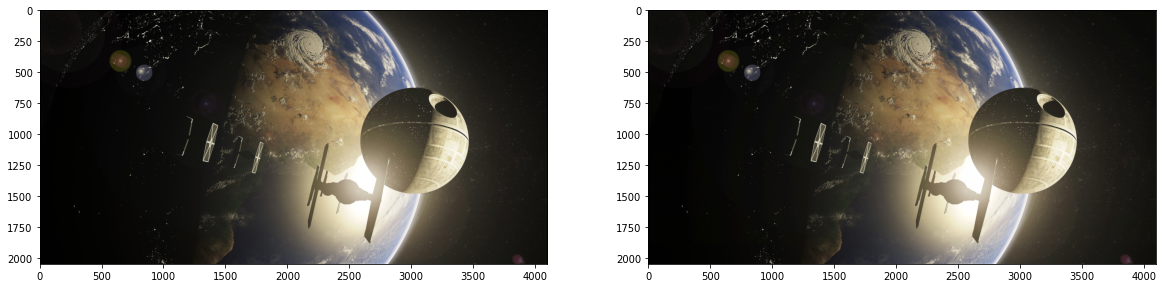

In [33]:
CompareTwoImages(death_star_hd_img, nested_img)

Looking good so far, now onto the finale.

# Decode the Series

Decoded Death Star


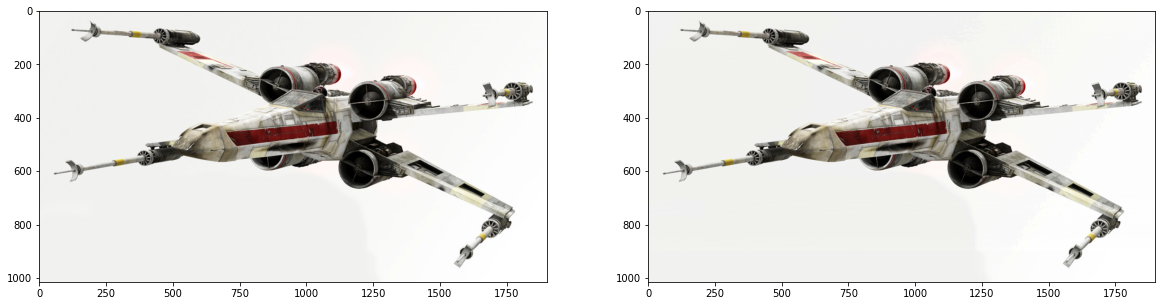

Decoded X-Wing


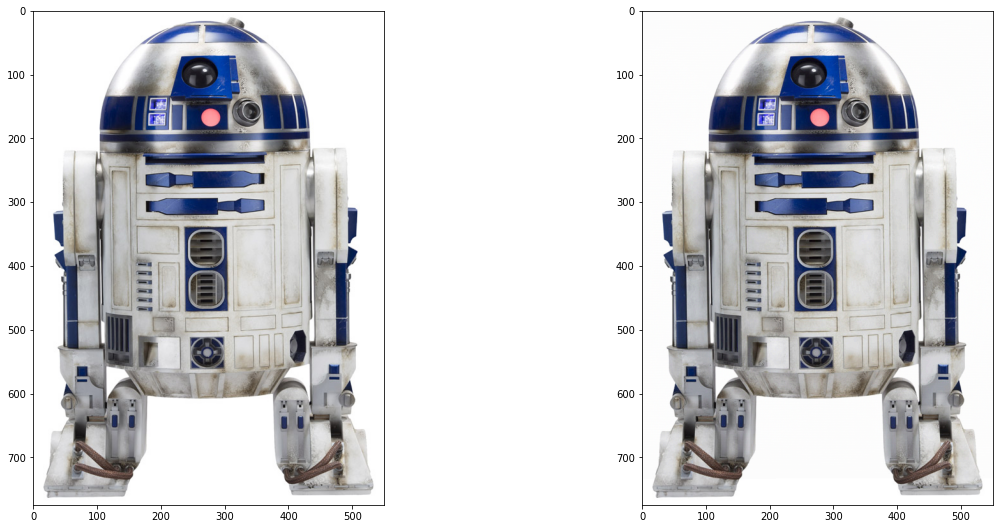

Decoded R2D2


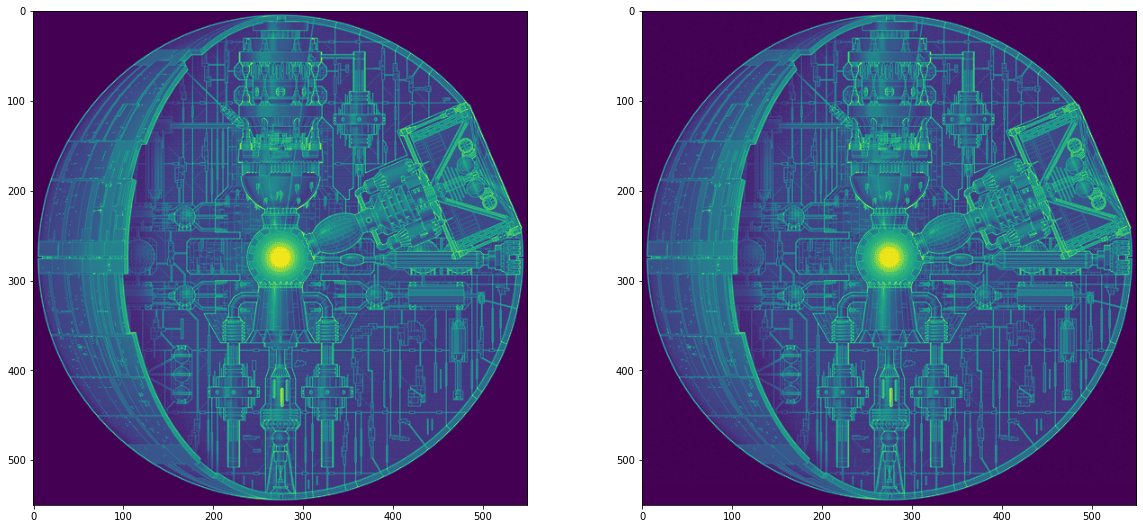

Decoded Death Star Plans
THREEPIO: Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!  
 THREEPIO: We're doomed!  
 THREEPIO: There'll be no escape for the Princess this time.  
 THREEPIO: What's that?  
 THREEPIO: I should have known better than to trust the logic of a half-sized thermocapsulary dehousing assister...  
 LUKE: Hurry up!  Come with me!  What are you waiting for?!  Get in gear!  
 THREEPIO: Artoo! Artoo-Detoo, where are you?  
 THREEPIO: At last!  Where have you been?  
 THREEPIO: They're heading in this direction. What are we going to do?  We'll be sent to the spice mines of Kessel or smashed into who knows what!  
 THREEPIO: Wait a minute, where are you going?  
 IMPERIAL: OFFICER The Death Star plans are not in the main computer.  
 VADER: Where are those transmissions you intercepted?  
 REBEL: OFFICER We intercepted no transmissions. Aaah...  This is a consular ship. Were on a diplomatic mission.  
 VADER: If this

In [34]:
%%time
decoded_xwing = DecodeImage(nested_img)
print("Decoded Death Star")
CompareTwoImages(r_xwing_img, decoded_xwing)
decoded_r2d2 = DecodeImage(decoded_xwing)
print("Decoded X-Wing")
CompareTwoImages(r2d2_img, decoded_r2d2)
decoded_plans = DecodeImage(decoded_r2d2)
print("Decoded R2D2")
CompareTwoImages(plans_img, decoded_plans)
decoded_new_hope = DecodeImage(decoded_plans)
print("Decoded Death Star Plans")
print(decoded_new_hope[:1000])

Fantastic, we have encoded a series of images inside other images. Just save them and we are done.

# Save Final Images

In [35]:
skimage.io.imsave("Encoded_Death_Star_HD.jpg", nested_img)
skimage.io.imsave("Encoded_X-Wing.jpg", decoded_xwing)
skimage.io.imsave("Encoded_R2D2.jpg", decoded_r2d2)
skimage.io.imsave("Encoded_Death_Star_Plans.jpg", decoded_plans)

# Wrapping up
This was a fun and interesting project to engage in. I hope it introduces people to Steganography techniques. This notebook should function like the invisible ink toy equivalent to Steganography. I encourage people to play around with image Steganography and see what they can do. Naturally, if we were really trying to hide messages in images, we would at least add layers of encryption to our messages and not use public images. Regardless, Image Steganography is most often used for adding hidden watermarks to images and videos for copyright purposes. Let's leave with one last quick method to scramble the last 2 bits of an image to delete any least significant bit encoding from an image.


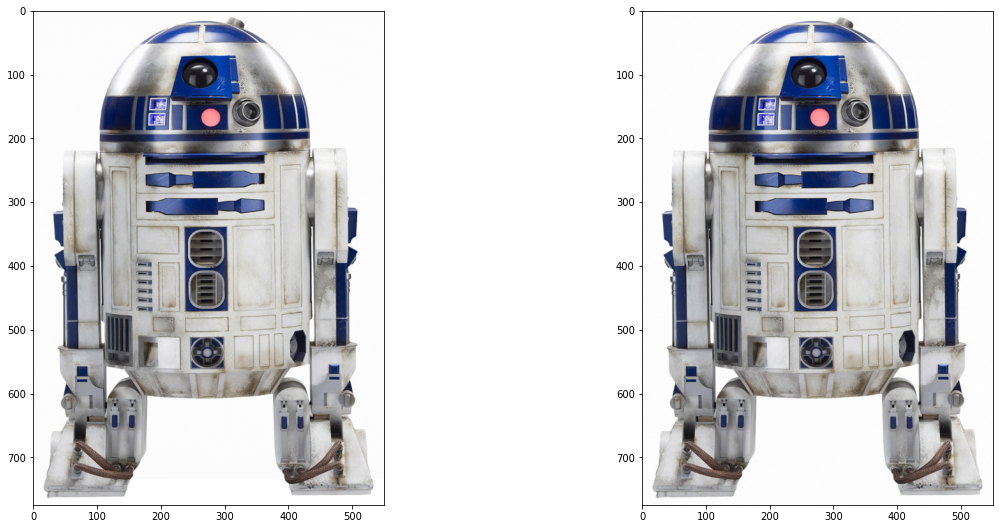

Wall time: 5.27 s


In [36]:
%%time
import random
def ScrambleEncodedImage(img):
    shape = img.shape
    img = img.flatten()
    for i,x in enumerate(img):
        r = [str(random.randint(0,1)),str(random.randint(0,1))]
        zbits = list('{0:08b}'.format(x))[:6]+r
        img[i] = int("".join(zbits), 2)
    return img.reshape(shape)

scrambled_img = ScrambleEncodedImage(decoded_r2d2)
CompareTwoImages(decoded_r2d2, scrambled_img)

# Acknowledgements

I was inspired to make this notebook based on this video by Computerphile on Steganography: https://www.youtube.com/watch?v=TWEXCYQKyDc

R2D2, X-Wing, and Death Star Plans come from Wookieepedia

Death Star HD Wallpaper from hipwallpaper.com

And, of course, the Star Wars Movie Scripts Kaggle dataset posted by Xavier
